# `pyutils` multifile  

## Introduction 

This turorial is intended to show users how to handle multiple input files using `pyutils`, either using local file lists, remote file lists, and SAM definitions. We cover simple array-based processing and more complex custom processing.

## Table of contents
1. Setup
1. Simple processing
1. Complex processing with the `Skeleton` template class

## 1. Setup

As in [pyutils_basics.ipynb](pyutils_basics.ipynb), we need to add `pyutils` to our Python path.

In [1]:
import sys 
sys.path.append("../../utils/pyutils")

## 2. Simple processing

The `process_data` function from `pyprocess` can be used to multithread processes on a list of EventNtuple files. This will work with both local and remote files. 

The default behaviour is to return the results as a single concatenated awkward array, which works well for small datasets. As will be discussed in example 3, you can customise the "process function" to run whatever task you need against each file, where the output will be a list of results from your function. 



In [2]:
# Import the Processor class from pyprocess 
from pyprocess import Processor 

# Initialise the Processor class instance
# If files are 
processor = Processor(
    # use_remote = True, 
    # location = "disk",
    verbosity = 2 
)

# Define path to list of 10 local files
# "Local" means that each file name includes the full path to a localtion on a local disk, such as `/exp/data`. 
file_list_path = "/exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/local_file_list.txt"
# file_list_path = "/exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/remote_file_list.txt"

# Define branches
# Branches can also be defined as a list of a grouped dict of lists, depending on requirements
branches = [
    "event",
    "trk.nactive",
    "trkqual.result",
    "crvcoincs.PEs",
    "trksegs"
]

# Process the files using multithreading
data = processor.process_data(
    file_list_path = file_list_path, 
    # defname = defname, # Alternatively, you can provide a SAM definition
    branches = branches
)

[pyprocess] ✅ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = False
	verbosity=2
[pyprocess] Loading file list from /exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/local_file_list.txt
[pyprocess] ✅ Successfully loaded file list
	Path: /exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/local_file_list.txt
	Count: 10 files
[pyprocess] Starting processing on 10 files with 10 workers


Processing: 100%|██████████████████████████████| 10/10 [00:04<00:00,  2.39file/s, succesful=10, fail


[pyprocess] ✅ Returning concatenated array containing 70255 events
[pyprocess] Array structure:
70255 * {
    event: int32,
    "trk.nactive": var * int32,
    trksegs: var * var * struct[{
        mom: struct[{
            fCoordinates: struct[{
                fX: float32,
                fY: float32,
                fZ: float32
            }, parameters={"__record__": "ROOT::Math::Cartesian3D<float>"}]
        }, parameters={"__record__": "ROOT::Math::DisplacementVector3D<ROOT::Math::Cartesian3D<float>,ROOT::Math::DefaultCoordinateSystemTag>"}],
        pos: struct[{
            fCoordinates: struct[{
                fX: float32,
                fY: float32,
                fZ: float32
            }, parameters={"__record__": "ROOT::Math::Cartesian3D<float>"}]
        }, parameters={"__record__": "ROOT::Math::DisplacementVector3D<ROOT::Math::Cartesian3D<float>,ROOT::Math::DefaultCoordinateSystemTag>"}],
        time: float64,
        dmom: float32,
        momerr: float32,
        i

We now have a concatenated awkward array called `data` which can be used for analysis.

> **Note**: Be mindful of memory constraints with large datasets.

## 3. Complex processing with the `Skeleton` template class
   
The `pyprocess` framework provides tools for complex processing on large datasets where simple array-based approaches become impractical due to memory constraints. The `Skeleton` processor class provides access to pre-written methods which leverage the tools in the main `Processor` class, limiting the amount of custom code required, while also providing the flexiblity to override methods as needed. 

In this example, we will learn how to use the Skeleton to accumulate histograms from multiple files. 

In [2]:
# Import required external packages
import awkward as ak    
import numpy as np      

# Import the framework classes
from pyprocess import Skeleton # The base template class that provides structure
from pyimport import Importer # Used to extract the data from ROOT files

# Create your custom processor class
# We inherit from Skeleton - this gives us many pre-built methods without writing extra code
class MyProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    
    def __init__(self):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class's __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        # Now override parameters from the Skeleton with the ones we need
        # Data selection configuration 
        self.defname = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/local_file_list.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_249.txt"
        
        self.branches = ["crvcoincs.PEs"]
        self.use_remote = True # Use remote file via mdh
        self.location = "disk" # File location
        self.max_workers = 100 # Limit the number of worker threads

        # Now add your own analysis-specific parameters 
        # Histogram configuration: 1000 bins ranging from 0 to 10000
        self.nbins = 1000         
        self.xrange = (0, 10000)  

        # Custom prefix for log messages from this processor
        self.print_prefix = "[MyProcessor] "
        print(f"{self.print_prefix}Initialised")
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class's process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name):
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create an Importer to extract data from this file
            # This uses the configuration parameters from our class
            this_importer = Importer(
                file_name=file_name,            # The current file being processed
                branches=self.branches,         # Which branches to import
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0                     # Reduce output in worker threads
            )
            
            # Extract the data using the Importer
            this_data = this_importer.import_branches()
            
            # ---- Analysis ----
            
            # Flatten the nested array structure for easier analysis
            # This converts potentially complex nested arrays into a 1D array
            this_data = ak.flatten(this_data["crvcoincs.PEs"], axis=None)
            
            # Create a histogram from the flattened data
            counts, bin_edges = np.histogram(
                this_data,              # Input data
                bins=self.nbins,        # Number of bins
                range=self.xrange       # Range of values to include
            ) 
                
            # Return the histogram data
            # This will be collected by the execute method
            return counts, bin_edges 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error processing {file_name}: {e}")
            return None

# ==========================================
# Create and run the processor
# ==========================================
# Create an instance of our custom processor
my_processor = MyProcessor()

# Run the processor on all files
# The execute method comes from the Skeleton parent class
hists = my_processor.execute()

# At this point, 'hists' contains the results from all processed files
# You can now analyze, plot, or save these results

[Template] ✅ Template initialised
[MyProcessor] Initialised
[MyProcessor] Starting analysis
[pyutils] Setting environment variables for this process...
[pyutils] ✅ Environment variables set
[pyprocess] ✅ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=1
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
	Count: 817 files
[pyprocess] Starting processing on 817 files with 100 workers


Processing: 100%|██████████████████████████████| 817/817 [03:50<00:00,  3.54file/s, succesful=817, f

[pyprocess] ✅ Returning list of 817 result from custom process function
[MyProcessor] ✅ Analysis complete


> **Note**: Be mindful of the number of maximum number worker threads when working on a shared machine. If in doubt, use fewer workers, not more. 

At this point, 'hists' contains the results from all processed files
You can now analyse, plot, or save these results

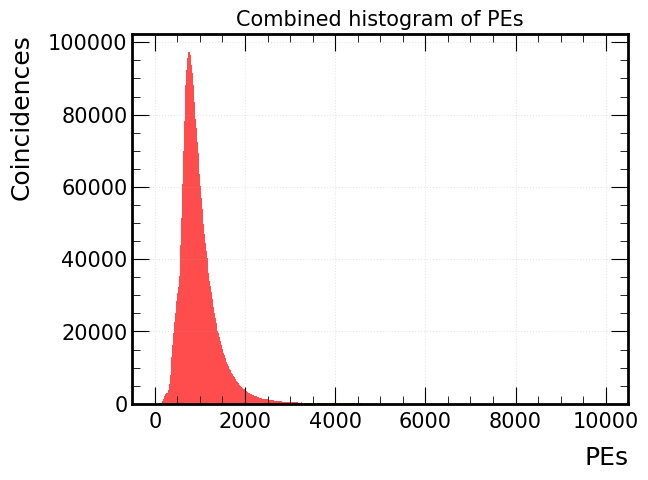

In [3]:
import matplotlib.pyplot as plt 

nbins = 1000
xrange = (0, 10000)

# Combine the histograms
combined_counts = np.zeros(nbins)

# Loop through the processed results and add the counts
for result in hists:
    if result is not None:  # Check that the processing was successful
        counts, _ = result  # Unpack the counts and bin_edges
        # Convert awkward array to numpy array if needed
        if hasattr(counts, 'to_numpy'):
            counts = counts.to_numpy()
        elif not isinstance(counts, np.ndarray):
            counts = np.array(counts)
        # Now add to the combined histogram
        combined_counts += counts

# Create the bin centres for plotting
bin_centres = np.linspace(
    xrange[0] + (xrange[1] - xrange[0])/(2*nbins),
    xrange[1] - (xrange[1] - xrange[0])/(2*nbins),
    nbins
)

# Plot the combined histogram
plt.style.use("mu2e.mplstyle") 
plt.figure()
plt.bar(bin_centres, combined_counts, width=(xrange[1] - xrange[0])/nbins, alpha=0.7)
plt.xlabel('PEs')
plt.ylabel('Coincidences')
plt.title('Combined histogram of PEs')
plt.grid(True, alpha=0.3)
plt.show()
        

In [6]:
# # Import external packages
# import awkward as ak
# import numpy as np

# # Import the Processor class from pyprocess 
# from pyprocess import Processor  
# from pyprocess import Importer  

# class MyFileProcessor:

#     def __init__(self):
#         """Initialise your file processor"""

#         # Define import parameters 
#         # self.defname = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"
#         self.file_list_path = "/exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/local_file_list.txt"
#         self.branches = ["crvcoincs.PEs"]
#         self.use_remote = False
#         self.location = "disk"
#         self.verbosity = 1 

#         # Histogram parameters
#         self.nbins = 1000
#         self.xrange = (0, 10000)

#         # Printout marker
#         self.print_prefix = "[MyFileProcessor] "

#         # Initialise the processor
#         processor = Processor(
#             dir_name=self.dir_name,
#             tree_name=self.tree_name,
#             use_remote=self.use_remote,
#             location=self.location,
#             schema=self.schema,
#             verbosity=self.verbosity
#         )

#         print(f"{self.print_prefix}Initialised")

#     # Define our process function 
#     def process_file(self, file_name):
#         """ Define our process to be run against every file"""
#         try:
#             # Create an Importer for this process
#             this_importer = Importer(
#                 file_name=file_name,
#                 branches=self.branches,
#                 use_remote=self.use_remote,
#                 location=self.location,
#                 verbosity=0 # Reduce verbosity for worker threads
#             )
            
#             # Get the data for this process
#             this_data = this_importer.import_branches()

#             # Flatten it for histogramming 
#             this_data = ak.flatten(this_data["crvcoincs.PEs"], axis=None)

#             print(this_data)

#             # Fill the histogram 
#             counts, bin_edges = np.histogram(this_data, bins=self.nbins, range=self.xrange) 
                
#             # Return the histogram tuple
#             return counts, bin_edges 
        
#         except Exception as e:
#             print(f"{self.print_prefix}Error processing {file_name}: {e}")
#             return None

#     def run(self):

#         print(f"{self.print_prefix}Running")

#         # Initialise the pyprocess Processor 
#         processor = Processor(
#             use_remote = self.use_remote,
#             location = self.location, 
#             verbosity = self.verbosity       
#         ) 

#         # Process the files into histograms
#         hists = processor.process_data(
#             file_list_path = self.file_list_path, 
#             custom_process_func = self.my_process
#         )

#         print(f"{self.print_prefix}Done")
#         return hists
    
# my_processor = MyFileProcessor()
# hists = my_processor.run()

In [8]:
# print(hists[0])

{'file_name': '/exp/mu2e/data/users/sgrant/EventNtuple/TestFiles/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00005260.root', 'event_count': 6866}


We now have a list of histogram objects which can be combined and plotted, as shown below.

In [11]:
# # Import external packages
# import awkward as ak
# import numpy as np
# import matplotlib.pyplot as plt 

# # Import the Processor class from pyprocess 
# from pyprocess import Processor  

# # Initiliase the Processor 
# processor = Processor(verbosity = 1) 

# # Define a SAM definition (817 files)
# defname = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"

# # Get our file list 
# file_list = processor.get_file_list(defname=defname)

# # Slice the file list to get the first 10 files, just for the sake of the example.
# # In principle, this method should be far more memory efficient than returing arrays,
# # and should work for the entire dataset 
# file_list = file_list[:10]

# # Define our branches 
# # We just want the parameter we are filling the histogram with 
# branches = [ "crvcoincs.PEs" ] 

# # Define number of bins and range
# nbins = 1000
# xrange = (0, 10000)

# # Define our process function which will be executed by each worker thread 
# def process(file_name): 
#     # Start an Importer instance 
#     local_importer = Importer(
#         use_remote=True,
#         location="disk",
#         verbosity=0
#     )
#     # Import the branches
#     local_data = local_importer.import_file(
#         file_name = file_name,
#         branches = branches
#     )
#     # Flatten the data
#     PEs = ak.flatten(local_data["crvcoincs.PEs"], axis=None)
#     # Fill the histogram 
#     counts, bin_edges = np.histogram(PEs, bins=nbins, range=xrange) 
#     # Return the histogram
#     return counts, bin_edges 
    
# # Run the processor, which will return a list of results
# processed_hists = processor.process_files_parallel(
#     file_list = file_list,
#     process_func = process,
#     max_workers = 10 # Control the number of workers 
# )

[pyprocess] ✅  Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
	Count: 817 files
[pyprocess] Starting processing on 10 files with 10 workers
[pyprocess] ✅  Done: 10/10 files processsed


> **Note**: I am not using `pyplot` here because at present it only works with flattened arrays, not histogram objects.